In [ ]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from matplotlib.colors import LinearSegmentedColormap
# from matplotlib import colormaps
import matplotlib.gridspec as gridspec
import pandas as pd
from picconfig import predpath, survpath, phedefpath, phecodespath, phecatpath, trainpath, temppath, outputpath
sys.path.append(trainpath)
# import survutil


In [26]:
class pheNN(nn.Module):
    def __init__(self, input_size, output_size, depth, width):
        super(pheNN, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(nn.Linear(width, width))
        self.inlayer = nn.Linear(input_size, width)
        self.layers = nn.ModuleList(layers)
        self.outlayer = nn.Linear(width, output_size)

    def forward(self, x):
        x = self.inlayer(x)
        for layer in self.layers:
            x = layer(x)
            x = nn.ReLU()(x)
        x = self.outlayer(x)
        return x

    def initialize(self):
        pass

class DeepSurv(nn.Module):
    def __init__(self, input_size, output_size, depth, width):
        super(DeepSurv, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(nn.Linear(width, width))

        normalization = []
        for i in range(depth):
            normalization.append(nn.BatchNorm1d(width,affine=False))
        self.inlayer = nn.Linear(input_size, width)
        self.layers = nn.ModuleList(layers)
        self.normalization = nn.ModuleList(normalization)
        self.outlayer = nn.Linear(width, output_size)
        self.initialize()

    def forward(self, x):
        x = self.inlayer(x)
        for (layer, normal) in zip(self.layers, self.normalization):
            x = layer(x)
            x = normal(x)
            x = nn.SELU()(x)
        x = self.outlayer(x)
        return x
    
    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

In [29]:
model = torch.load("../../results/weights/pred/610_3model", map_location=torch.device('cpu'))
corrprediction=model.outlayer.weight.data.to('cpu').numpy()
model_surv = torch.load("../../results/weights/surv/610_0model", map_location=torch.device('cpu'))
corrsurvival=model_surv.outlayer.weight.cpu().detach().numpy()

In [ ]:

random.seed(0)
np.random.seed(0)
X = corrprediction
tsne = TSNE()
X_tsne_prediction = tsne.fit_transform(X)


In [30]:
X_tsne_prediction.shape
corrsurvival.shape

(1560, 300)

In [6]:
X_tsne_prediction.shape

(1560, 2)

In [31]:
phecode_col = pd.read_csv("../../data/phecode.csv")
phecat = np.load(phecatpath, allow_pickle=True)[0]
# phecat

In [14]:
# Convert dictionary to two-column DataFrame
rows = []
for category, indices in phecat.items():
    for index in indices:
        rows.append([index, category])

df = pd.DataFrame(rows, columns=["Row_Number", "Category"])

# Save DataFrame to CSV
output_path = "/Users/kanny/Documents/GitHub/Pipline-UKB/results/cache/multimorbidity/phecat_rows_and_categories.csv"
df.to_csv(output_path, index=False)

In [9]:
phecode_col.astype(str)

,Phecode
0,8.0
1,8.5
2,8.51
3,8.52
4,8.6
...,...
1555,1012.0
1556,1013.0
1557,1014.0
1558,1015.0


In [32]:
# Save
phecode_col = phecode_col["Phecode"].astype(str).reset_index(drop=True)

# Convert to DataFrame with updated column names
corrprediction_df = pd.DataFrame(corrprediction, index=phecode_col)
corrsurvival_df = pd.DataFrame(corrsurvival, index=phecode_col)
X_tsne_prediction_df = pd.DataFrame(X_tsne_prediction, columns=["TSNE_1", "TSNE_2"], index=phecode_col)

# Save as CSV
corrprediction_df.to_csv("/Users/kanny/Documents/GitHub/Pipline-UKB/results/cache/multimorbidity/multimorbidity.csv", index_label="Phecode")
corrsurvival_df.to_csv("/Users/kanny/Documents/GitHub/Pipline-UKB/results/cache/multimorbidity/multimorbidity_surv.csv", index_label="Phecode")
X_tsne_prediction_df.to_csv("/Users/kanny/Documents/GitHub/Pipline-UKB/results/cache/multimorbidity/X_tsne_prediction.csv", index_label="Phecode")


In [ ]:
num_diseases = 1560
disease_vectors = X_tsne_prediction.copy()

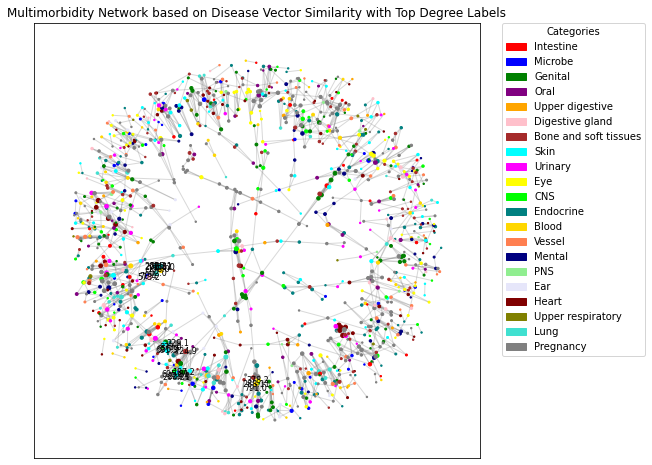

Network statistics:
Number of nodes: 1560
Number of edges: 1984
Average degree: 2.5435897435897434
Average clustering coefficient: 0.4954782254782252
Modularity (using Louvain method): 0.9865645261274252


In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain  # Importing Louvain method from the python-louvain package
import matplotlib.patches as mpatches  # 用于创建自定义图例

# 假设 X_tsne_prediction 是疾病的特征向量矩阵，phecat 是类别字典，phecode_col 是 Phecode 的 DataFrame
np.random.seed(0)
# similarity_matrix = cosine_similarity(X_tsne_prediction) # 使用实际的 X_tsne_prediction 数据

# 创建每个类别的颜色映射
category_colors = {
    "Intestine": "red", "Microbe": "blue", "Genital": "green", "Oral": "purple",
    "Upper digestive": "orange", "Digestive gland": "pink", "Bone and soft tissues": "brown",
    "Skin": "cyan", "Urinary": "magenta", "Eye": "yellow", "CNS": "lime",
    "Endocrine": "teal", "Blood": "gold", "Vessel": "coral", "Mental": "navy",
    "PNS": "lightgreen", "Ear": "lavender", "Heart": "maroon", "Upper respiratory": "olive",
    "Lung": "turquoise", "Pregnancy": "grey"
}

# 计算疾病之间的余弦相似度矩阵
similarity_matrix = cosine_similarity(disease_vectors)

# 设置一个相似度阈值来构建网络的边，仅保留强相关的边
threshold = 0.99999
edges = []
for i in range(num_diseases):
    for j in range(i + 1, num_diseases):
        if similarity_matrix[i, j] >= threshold:
            edges.append((i, j, similarity_matrix[i, j]))

# 创建网络图
G = nx.Graph()
# 添加节点和边
G.add_nodes_from(range(num_diseases))  # 添加疾病节点
for i, j, weight in edges:
    G.add_edge(i, j, weight=weight)  # 添加符合阈值的边，边权重为相似度

# 根据 phecat 为每个节点分配颜色
node_colors = []
for node in G.nodes():
    # 找出该节点所属的类别
    node_category = next((cat for cat, nodes in phecat.items() if node in nodes), None)
    # 获取类别对应的颜色，如果未找到类别，则默认使用灰色
    color = category_colors.get(node_category, "gray")
    node_colors.append(color)

# 设置节点大小，随节点度数变化
node_size = [G.degree(n) * 2 for n in G.nodes()]

# 仅选择度数最大的20个节点来显示标签
top_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]
top_labels = {node: f"{phecode_col.iloc[node, 0]}" for node, _ in top_degree_nodes}

# 绘制图形
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=0, k=0.1, iterations=50)
# pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=top_labels, font_size=8)  # 仅绘制度数最高的节点标签

# 创建自定义图例
legend_handles = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_handles, title="Categories", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.title("Multimorbidity Network based on Disease Vector Similarity with Top Degree Labels")
plt.show()

# 输出网络的统计信息
print("Network statistics:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", np.mean([G.degree(n) for n in G.nodes()]))
print("Average clustering coefficient:", nx.average_clustering(G))

# 使用 Louvain 方法计算模块度
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
print("Modularity (using Louvain method):", modularity)


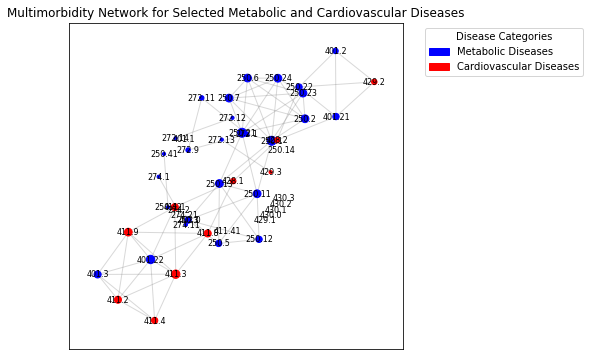

Network statistics:
Number of nodes: 48
Number of edges: 74
Average degree: 3.0833333333333335
Average clustering coefficient: 0.4948412698412698
Modularity (using Louvain method): 0.693143873461026


In [77]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain  # Importing Louvain method for community detection
import matplotlib.patches as mpatches  # For creating custom legends

# Define prefixes for metabolic and cardiovascular diseases
metabolic_prefixes = ["250", "272", "274", "401", "402"]  # Diabetes, Hyperlipidemia, etc.
cardio_prefixes = ["410", "411", "428", "429", "430"]  # Myocardial Infarction, Stroke, etc.

phecode_col = phecode_col.astype(str)
# phecode_col = phecode_col.to_numpy()
# 假设 phecode_col 是所有 PheCode 的列表，disease_vectors 是疾病特征向量矩阵
# phecode_col = ["250.00", "272.10", "410.00", "411.10", ...]
# disease_vectors = np.array([...])  # 对应的特征矩阵

# Function to extract indices of PheCodes matching prefixes
def extract_phecode_indices(phecode_list, prefixes):
    return [i for i, phecode in enumerate(phecode_list) if any(str(phecode[0]).startswith(prefix) for prefix in prefixes)]

# Extract indices for metabolic and cardiovascular diseases
metabolic_indices = extract_phecode_indices(phecode_col, metabolic_prefixes)
cardio_indices = extract_phecode_indices(phecode_col, cardio_prefixes)

# Combine indices and select corresponding vectors and PheCodes
selected_indices = metabolic_indices + cardio_indices
selected_disease_vectors = disease_vectors[selected_indices]
selected_phecodes = [phecode_col[i] for i in selected_indices]

# Calculate similarity matrix for selected diseases
similarity_matrix = cosine_similarity(selected_disease_vectors)

# Set a threshold to create edges based on similarity
threshold = 0.999  # Adjust as needed to control network density
edges = []
num_selected = len(selected_phecodes)
for i in range(num_selected):
    for j in range(i + 1, num_selected):
        if similarity_matrix[i, j] >= threshold:
            edges.append((i, j, similarity_matrix[i, j]))

# Create the network graph
G = nx.Graph()
G.add_nodes_from(range(num_selected))  # Add nodes for each selected disease
for i, j, weight in edges:
    G.add_edge(i, j, weight=weight)  # Add edges with weights based on similarity

# Assign colors based on metabolic and cardiovascular categories
node_colors = []
for idx in selected_indices:
    phecode = phecode_col[idx][0]
    if any(str(phecode).startswith(prefix) for prefix in metabolic_prefixes):
        node_colors.append("blue")  # Metabolic diseases use blue
    elif any(str(phecode).startswith(prefix) for prefix in cardio_prefixes):
        node_colors.append("red")   # Cardiovascular diseases use red
    else:
        node_colors.append("gray")

# Node size based on degree
node_size = [G.degree(n) * 10 for n in G.nodes()]

# Only display labels for the top 20 nodes by degree
top_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:]
top_labels = {node: selected_phecodes[node][0] for node, _ in top_degree_nodes}

# Plot the network graph
plt.figure(figsize=(6, 6))
# pos = nx.spring_layout(G, seed=0, k=0.5, iterations=100)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=top_labels, font_size=8)  # 仅绘制度数最高的节点标签

# Create custom legend for categories
legend_handles = [
    mpatches.Patch(color="blue", label="Metabolic Diseases"),
    mpatches.Patch(color="red", label="Cardiovascular Diseases")
]
plt.legend(handles=legend_handles, title="Disease Categories", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Multimorbidity Network for Selected Metabolic and Cardiovascular Diseases")
plt.show()

# Output network statistics
print("Network statistics:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", np.mean([G.degree(n) for n in G.nodes()]))
print("Average clustering coefficient:", nx.average_clustering(G))

# Calculate modularity using Louvain method
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
print("Modularity (using Louvain method):", modularity)


In [68]:
selected_phecodes[0][0]



'250.1'

In [58]:

# Define prefixes for metabolic and cardiovascular diseases
metabolic_prefixes = ["250", "272", "274", "401", "402"]  # Diabetes, Hyperlipidemia, etc.
cardio_prefixes = ["410", "411", "428", "429", "430"]  # Myocardial Infarction, Stroke, etc.

phecode_col = phecode_col.astype(str)

# 假设 phecode_col 是所有 PheCode 的列表，disease_vectors 是疾病特征向量矩阵
# phecode_col = ["250.00", "272.10", "410.00", "411.10", ...]
# disease_vectors = np.array([...])  # 对应的特征矩阵

# Function to extract indices of PheCodes matching prefixes
def extract_phecode_indices(phecode_list, prefixes):
    return [i for i, phecode in enumerate(phecode_list.to_numpy()) if any(str(phecode[0]).startswith(prefix) for prefix in prefixes)]

# Extract indices for metabolic and cardiovascular diseases
metabolic_indices = extract_phecode_indices(phecode_col, metabolic_prefixes)
metabolic_indices
# phecode_list = phecode_col
# prefixes = metabolic_prefixes
# # cardio_indices = extract_phecode_indices(phecode_col, cardio_prefixes)
# indices = []
# for i, phecode in enumerate(phecode_list.to_numpy()):
#     for prefix in prefixes:
#         if str(phecode[0]).startswith(prefix):
#             indices.append(i)
# indices

[187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 252,
 253,
 254,
 255,
 256,
 257,
 569,
 570,
 571,
 572,
 573,
 797,
 798,
 799,
 800,
 808,
 809,
 810,
 811,
 844]

In [55]:
str(phecode[0])

'1019.0'

In [73]:
phecat = np.load(phecatpath, allow_pickle=True)[0]
phecat

{'Intestine': [0,
  1,
  2,
  3,
  4,
  5,
  66,
  67,
  68,
  141,
  918,
  919,
  920,
  927,
  928,
  929,
  930,
  931,
  932,
  933,
  934,
  935,
  936,
  937,
  938,
  939,
  943,
  944,
  949,
  950,
  954,
  955,
  956],
 'Microbe': [6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  785,
  786,
  787],
 'Genital': [29,
  30,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  151,
  152,
  153,
  154,
  155,
  768,
  790,
  1046,
  1047,
  1048,
  1049,
  1050,
  1051,
  1052,
  1053,
  1054,
  1055,
  1056,
  1057,
  1058,
  1059,
  1060,
  1061,
  1062,
  1063,
  1064,
  1065,
  1066,
  1067,
  1068,
  1069,
  1070,
  1071,
  1072,
  1073,
  1074,
  1075,
  1076,
  1077,
  1078,
  1079,
  1080,
  1081,
  1082,
  1083,
  1084,
  

In [67]:
similarity_matrix

array([[ 1.        ,  0.9999755 ,  0.8770251 , ..., -0.7931294 ,
         0.18739103,  0.01042187],
       [ 0.9999755 ,  1.        ,  0.87364024, ..., -0.78884614,
         0.19426313,  0.01742196],
       [ 0.8770251 ,  0.87364024,  1.        , ..., -0.9882106 ,
        -0.30758685, -0.47127807],
       ...,
       [-0.7931294 , -0.78884614, -0.9882106 , ...,  0.99999994,
         0.44963866,  0.60075414],
       [ 0.18739103,  0.19426313, -0.30758685, ...,  0.44963866,
         1.        ,  0.98418504],
       [ 0.01042187,  0.01742196, -0.47127807, ...,  0.60075414,
         0.98418504,  1.        ]], dtype=float32)

/Users/kanny/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 30142 (\N{CJK UNIFIED IDEOGRAPH-75BE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kanny/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 30149 (\N{CJK UNIFIED IDEOGRAPH-75C5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kanny/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kanny/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kanny/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6})

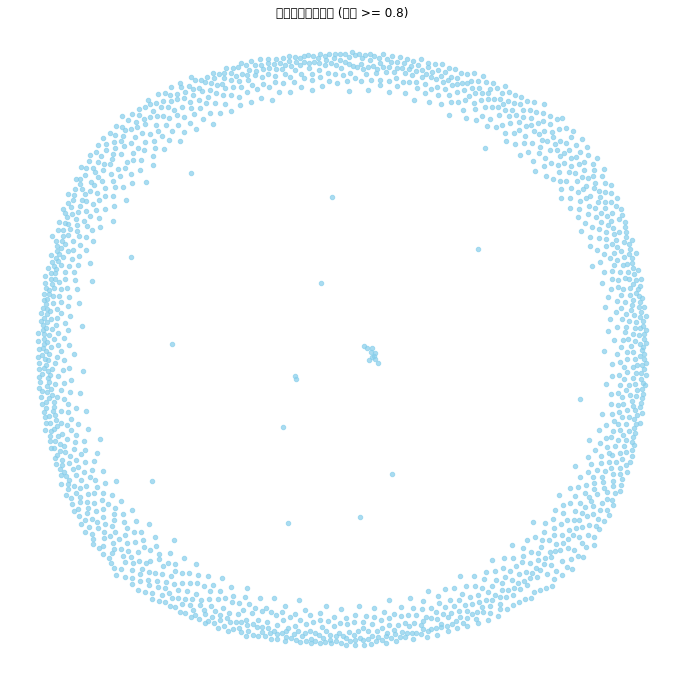

In [50]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 假设 corrprediction 是一个包含 1560 行疾病和 100 列特征的数据框
# 这里我们用随机数据创建一个示例
np.random.seed(0)
num_diseases = 1560
num_features = 100
# 使用真实的 disease_vectors 数据
# disease_vectors = np.random.rand(num_diseases, num_features)
disease_vectors = corrprediction

# 计算疾病之间的余弦相似度矩阵
similarity_matrix = cosine_similarity(disease_vectors)

# 设置一个相似度阈值来构建网络的边，仅保留强相关的边
threshold = 0.8  # 调整阈值以控制图的稠密度
edges = []
for i in range(num_diseases):
    for j in range(i + 1, num_diseases):
        if similarity_matrix[i, j] >= threshold:
            edges.append((i, j, similarity_matrix[i, j]))

# 创建网络图
G = nx.Graph()
# 添加节点和边
G.add_nodes_from(range(num_diseases))  # 添加疾病节点
for i, j, weight in edges:
    G.add_edge(i, j, weight=weight)  # 添加符合阈值的边，边权重为相似度

# 绘制网络图
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # 使用 spring 布局使图更清晰

# 根据权重绘制边的粗细
# edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
# nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w * 5 for w in weights], alpha=0.5)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.7)

# 隐藏节点标签以保持图的简洁
plt.title("疾病相似度网络图 (阈值 >= 0.8)")
plt.axis("off")
plt.show()


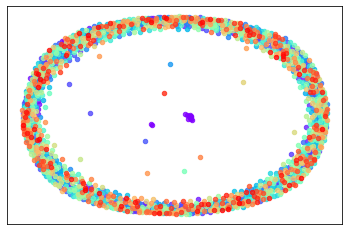

In [51]:
from networkx.algorithms.community import greedy_modularity_communities

# 检测社区
communities = greedy_modularity_communities(G)
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

# 按社区颜色绘制节点
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_size=20, 
                           node_color=[community_colors[i]], alpha=0.8)


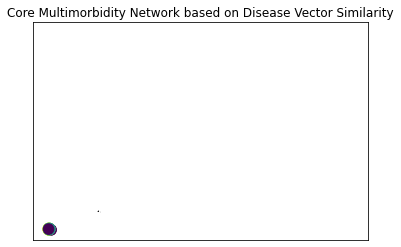

In [ ]:
# 只保留度数大于某个阈值的节点
core_nodes = [n for n in G.nodes if G.degree(n) > 0]  # 例如度数大于5
G_core = G.subgraph(core_nodes)  # 提取子图

# 绘制子图
pos = nx.spring_layout(G_core, seed=0, k=0.5, iterations=100)
nx.draw_networkx_nodes(G_core, pos, node_color=[G_core.degree(n) for n in G_core.nodes()], 
                       node_size=[100 + G_core.degree(n) * 10 for n in G_core.nodes()], cmap=plt.cm.viridis)
# nx.draw_networkx_edges(G_core, pos)
plt.title("Core Multimorbidity Network based on Disease Vector Similarity")
plt.show()


In [12]:
phecat = np.load(phecatpath, allow_pickle=True)[0]

In [10]:
random.seed(0)
np.random.seed(0)
X = corrprediction
tsne = TSNE()
X_tsne_prediction = tsne.fit_transform(X)
np.save("/Users/kanny/Documents/GitHub/Pipline-UKB/results/cache/tsne_prediction_dim2.npy", X_tsne_prediction)

# random.seed(0)
# np.random.seed(0)
# X = corrsurvival
# tsne = TSNE()
# X_tsne_survival = 0.8 * tsne.fit_transform(X)
# np.save("tsne_survival.npy", X_tsne_survival)

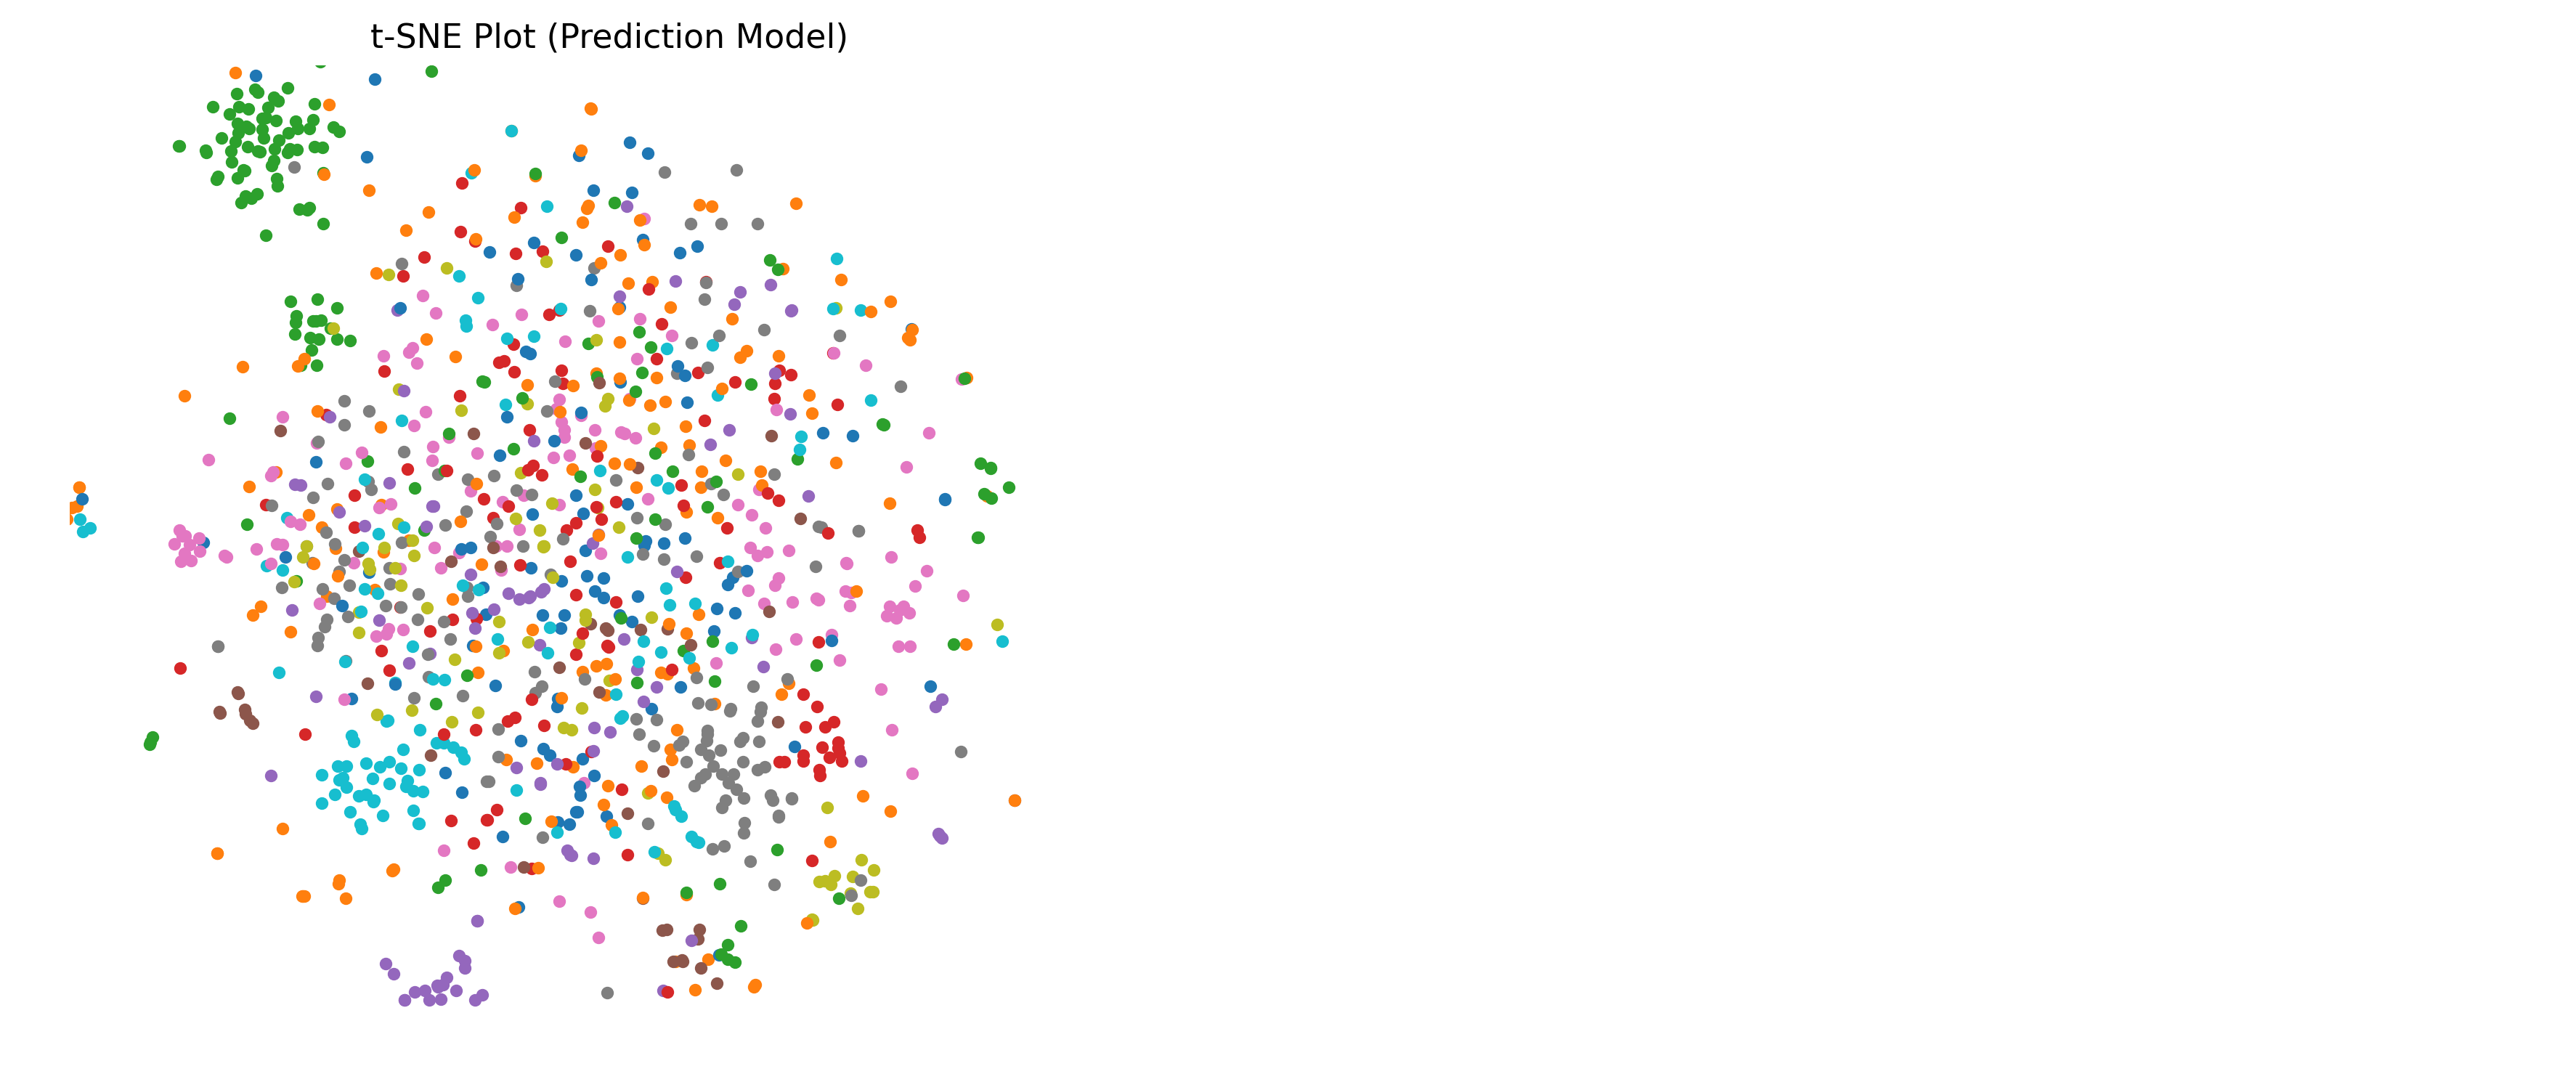

In [14]:
fig = plt.figure(figsize=(15, 6), dpi=300)
gs0 = gridspec.GridSpec(1, 4, figure=fig, wspace=-0.3, width_ratios = [0.05,0.95,1.05,0.01])
ax0 = fig.add_subplot(gs0[0, 0])
ax0.axis('off')
ax1 = fig.add_subplot(gs0[0, 1])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_prediction[v,:]
    marker='o'
    pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=10, label=k) 
    i+=1
handles, labels = ax1.get_legend_handles_labels()
unique_legend_dict = {}
for handle, label in zip(handles, labels):
    if label == 'Others':
        continue
    if label not in unique_legend_dict:
        unique_legend_dict[label] = handle

unique_labels = list(unique_legend_dict.keys())
unique_handles = [unique_legend_dict[label] for label in unique_labels]
title1 = 't-SNE Plot (Prediction Model)'
ax1.set_title(title1, fontsize=11)
# plot circles
ax1.axis('off')
ax1.set_aspect('equal')
ax1.set_xlim(-37,45)
ax1.set_ylim(-40,35)

title = 'sup_scatter'
ax3 = fig.add_subplot(gs0[0, 3])
ax3.axis('off')
# plt.savefig(outputpath + title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()

In [6]:
cm1 = colormaps['tab20']
cm2 = colormaps['Dark2']
colorlist=[]
for i in range(20):
    colorlist.append(cm1(i))
colorlist.append(cm2(0))
cm = LinearSegmentedColormap.from_list('sample', colorlist, N=21)

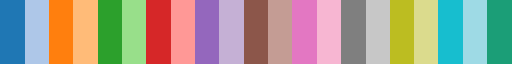

In [7]:
cm

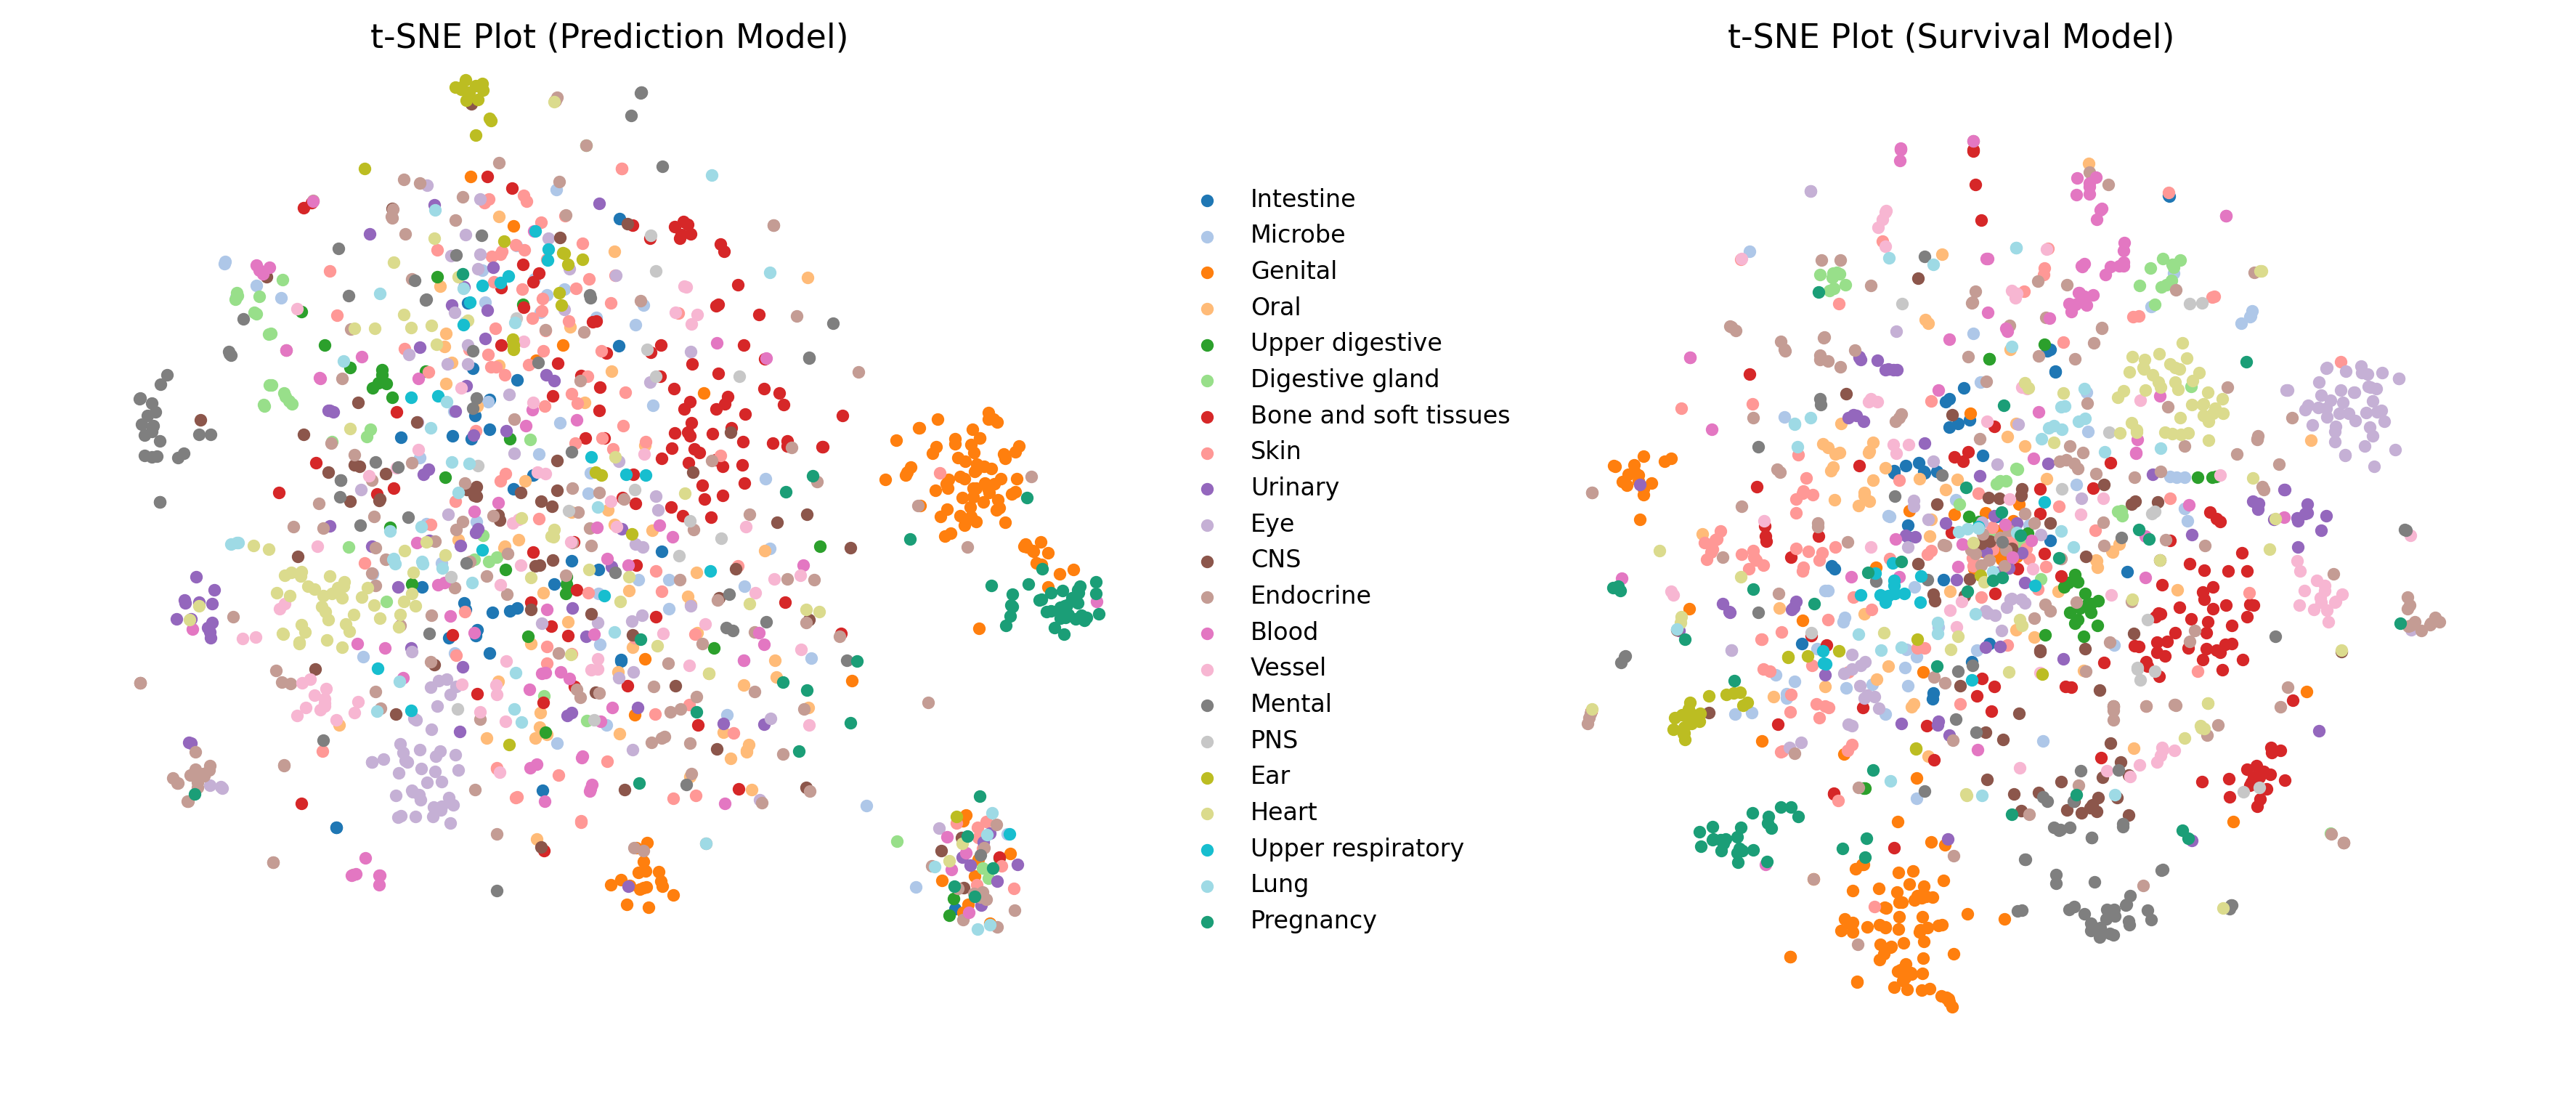

In [8]:
fig = plt.figure(figsize=(15, 6), dpi=300)
gs0 = gridspec.GridSpec(1, 4, figure=fig, wspace=-0.3, width_ratios = [0.05,0.95,1.05,0.01])
ax0 = fig.add_subplot(gs0[0, 0])
ax0.axis('off')
ax1 = fig.add_subplot(gs0[0, 1])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_prediction[v,:]
    marker='o'
    pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
    i+=1
handles, labels = ax1.get_legend_handles_labels()
unique_legend_dict = {}
for handle, label in zip(handles, labels):
    if label == 'Others':
        continue
    if label not in unique_legend_dict:
        unique_legend_dict[label] = handle

unique_labels = list(unique_legend_dict.keys())
unique_handles = [unique_legend_dict[label] for label in unique_labels]
title1 = 't-SNE Plot (Prediction Model)'
ax1.set_title(title1, fontsize=11)
# plot circles
ax1.axis('off')
ax1.set_aspect('equal')
ax1.set_xlim(-37,45)
ax1.set_ylim(-40,35)

ax2 = fig.add_subplot(gs0[0, 2])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_survival[v,:]
    marker='o'
    pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
    i+=1
title2 = 't-SNE Plot (Survival Model)'
ax2.set_title(title2, fontsize=11)
ax2.axis('off')
ax2.set_xlim(-50,40)
ax2.set_ylim(-40,40)
ax2.set_aspect('equal')
legend = ax2.legend(unique_handles, unique_labels, bbox_to_anchor=(0.13, 0.9), fontsize=8)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
title = 'sup_scatter'
ax3 = fig.add_subplot(gs0[0, 3])
ax3.axis('off')
plt.savefig(outputpath + title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()

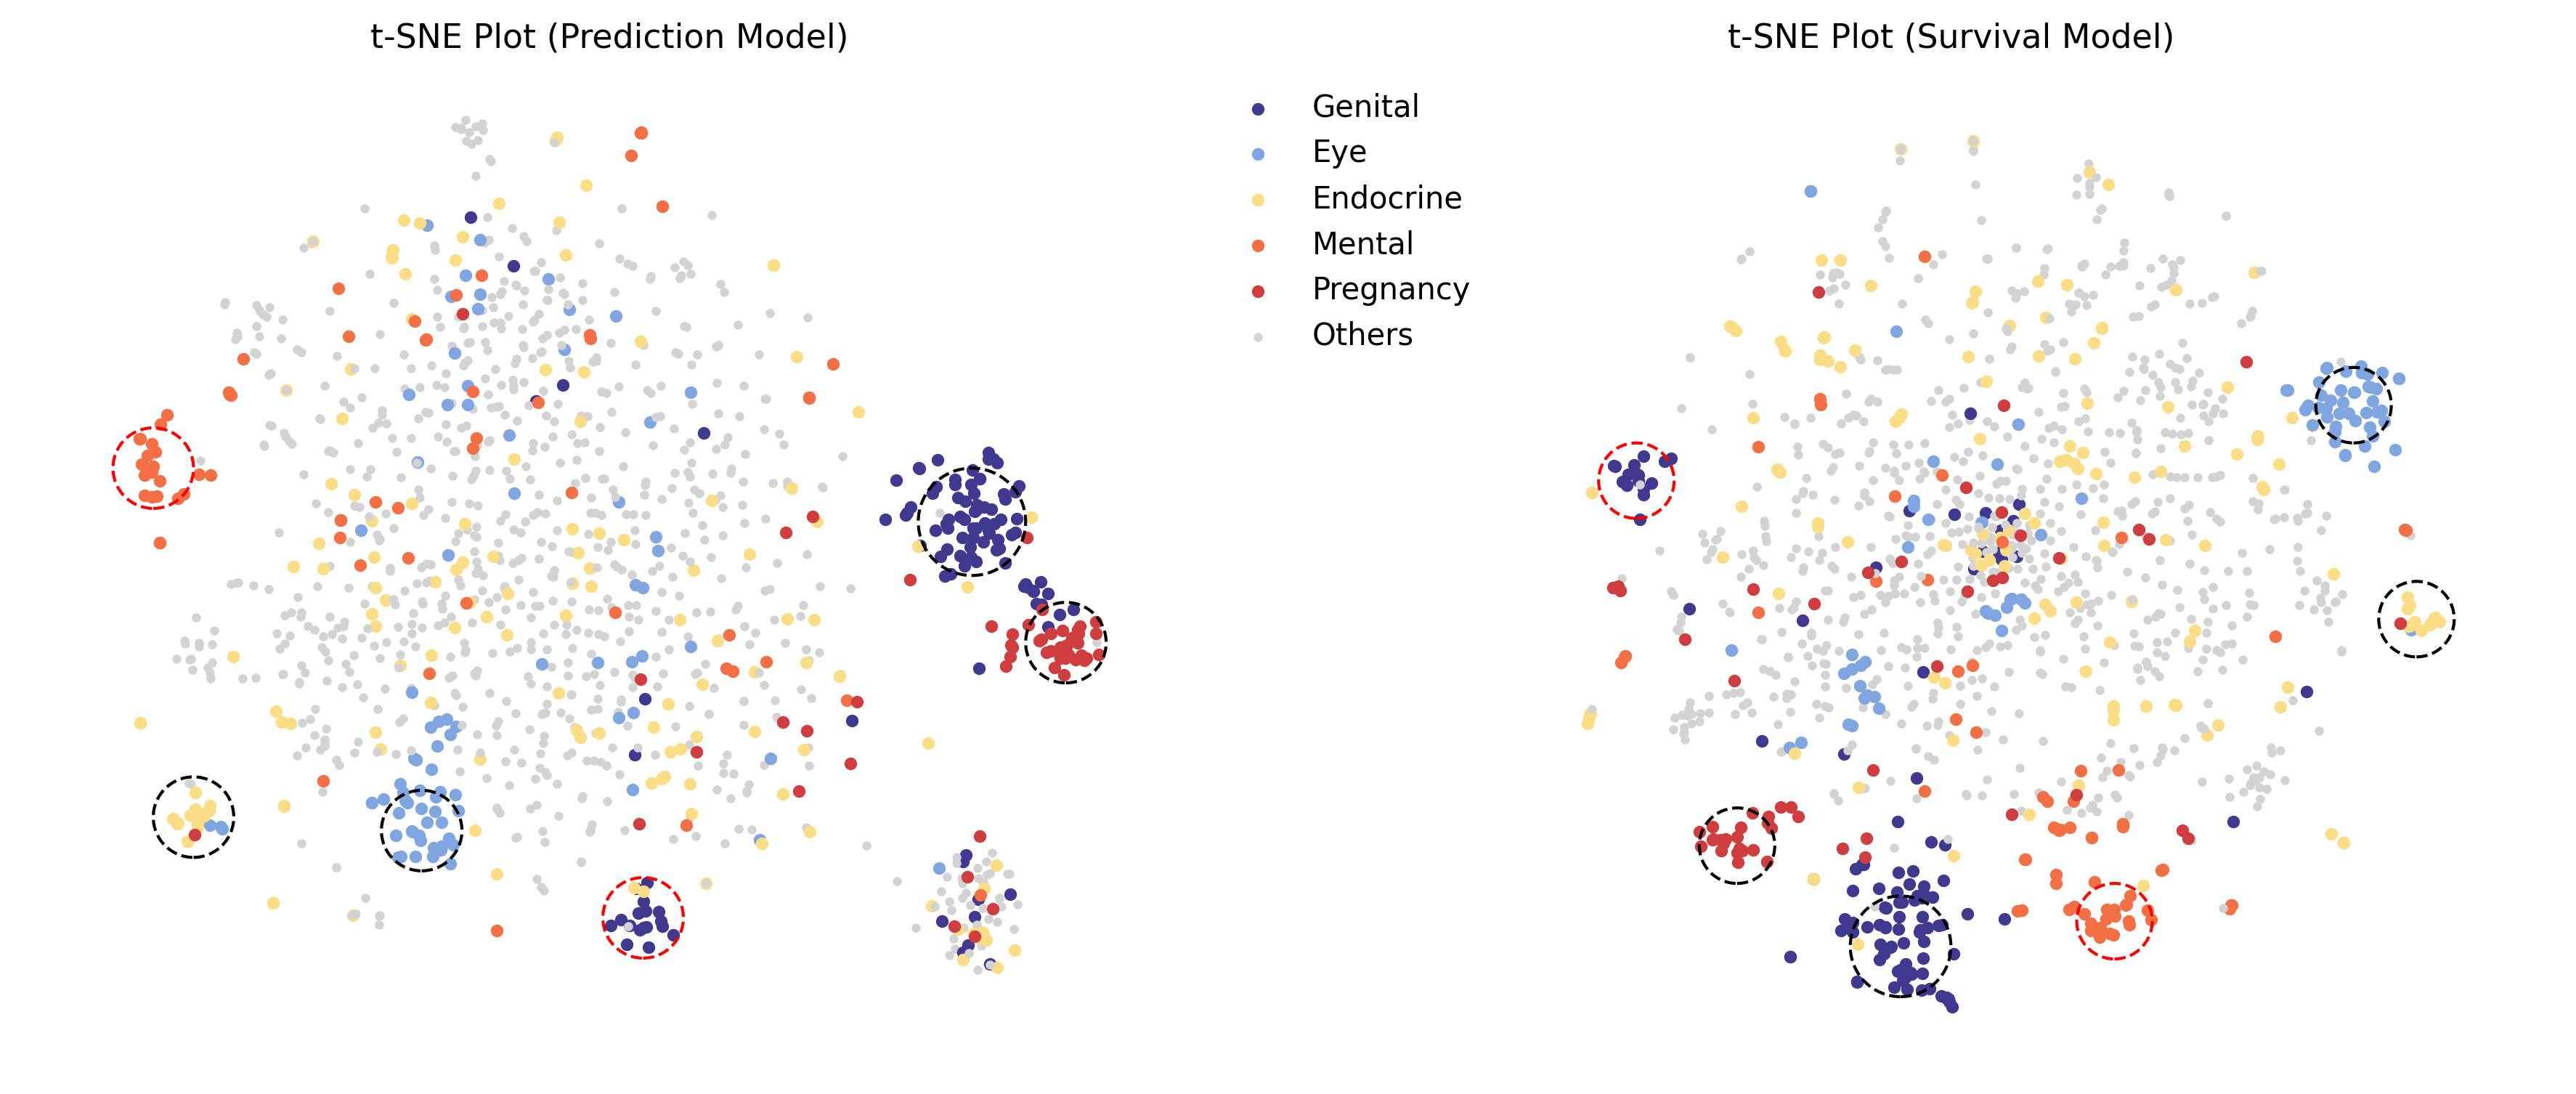

In [9]:
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=5)
fig = plt.figure(figsize=(15, 6), dpi=300)
gs0 = gridspec.GridSpec(1, 4, figure=fig, wspace=-0.3, width_ratios = [0.05,0.95,1.05,0.01])
ax0 = fig.add_subplot(gs0[0, 0])
ax0.axis('off')
ax1 = fig.add_subplot(gs0[0, 1])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_prediction[v,:]
    marker='o'
    if k in ['Genital', 'Pregnancy', 'Eye', 'Mental', 'Endocrine']:
        pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
        i+=1
    else:
        pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=4,color="#d3d3d3", label="Others") 
handles, labels = ax1.get_legend_handles_labels()
unique_legend_dict = {}
for handle, label in zip(handles, labels):
    if label == 'Others':
        continue
    if label not in unique_legend_dict:
        unique_legend_dict[label] = handle

unique_labels = list(unique_legend_dict.keys())
unique_handles = [unique_legend_dict[label] for label in unique_labels]
index = labels.index("Others")
unique_handles.append(handles[index])
unique_labels.append(labels[index])
title1 = 't-SNE Plot (Prediction Model)'
ax1.set_title(title1, fontsize=11)
# plot circles
c = plt.Circle((6.5,-25.5),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-30,8),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-27,-18),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((31,4),4, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-10,-19),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((38,-5),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
ax1.axis('off')
ax1.set_aspect('equal')
ax1.set_xlim(-37,45)
ax1.set_ylim(-37,38)

ax2 = fig.add_subplot(gs0[0, 2])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_survival[v,:]
    marker='o'
    if k in ['Genital', 'Pregnancy', 'Eye', 'Mental', 'Endocrine']:
        pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
        i+=1
    else:
        pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=4,color="#d3d3d3", label="Others") 
title2 = 't-SNE Plot (Survival Model)'
ax2.set_title(title2, fontsize=11)
c = plt.Circle((-30,7),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((8,-28),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((32,-4),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((-9,-30),4, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((27,13),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((-22,-22),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
ax2.axis('off')
ax2.set_xlim(-50,40)
ax2.set_ylim(-40,40)
ax2.set_aspect('equal')
legend = ax2.legend(unique_handles, unique_labels, bbox_to_anchor=(0.1, 1), fontsize=10)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
title = 't-SNE Plot'
ax3 = fig.add_subplot(gs0[0, 3])
ax3.axis('off')
plt.savefig(temppath+title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()